In [1]:
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
train_data = pd.read_csv('/Users/marlenawasiak/Desktop/Data_Collection/NSL_KDD_Train.csv')
test_data = pd.read_csv('/Users/marlenawasiak/Desktop/Data_Collection/NSL_KDD_Test.csv')

In [4]:
X_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]
X_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

# Align columns to keep only the common columns
common_columns = X_train.columns.intersection(X_test.columns)
X_train = X_train[common_columns]
X_test = X_test[common_columns]

In [7]:
# Encode labels with combined categories
all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [10]:
# Encode categorical features with consistent categories
categorical_columns = X_train.select_dtypes(include=['object']).columns
for col in categorical_columns:
    combined_categories = pd.concat([X_train[col], X_test[col]], axis=0).astype("category").cat.categories
    X_train[col] = pd.Categorical(X_train[col], categories=combined_categories)
    X_test[col] = pd.Categorical(X_test[col], categories=combined_categories)
    
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    
from sklearn.preprocessing import StandardScaler
# Define clipping thresholds based on the 99th percentile of the training data
clip_thresholds = {
    "0.1": X_train["0.1"].quantile(0.99),
    "0.2": X_train["0.2"].quantile(0.99)
}

# Clip the training and test data at these thresholds
X_train_clipped = X_train.copy()
X_test_clipped = X_test.copy()

for col, threshold in clip_thresholds.items():
    X_train_clipped[col] = X_train[col].clip(upper=threshold)
    X_test_clipped[col] = X_test[col].clip(upper=threshold)

from sklearn.preprocessing import RobustScaler

# Fit RobustScaler on the training data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_clipped)
X_test_scaled = scaler.transform(X_test_clipped)

# Verify the new scaled ranges
print("Scaled feature ranges after RobustScaler:")
print("Train set min:", X_train_scaled.min(), "max:", X_train_scaled.max())
print("Test set min:", X_test_scaled.min(), "max:", X_test_scaled.max())

from sklearn.preprocessing import QuantileTransformer
import numpy as np

# Apply QuantileTransformer with a normal distribution
scaler = QuantileTransformer(output_distribution='normal')  # Alternatively, try 'uniform' if normal doesn't work well
X_train_scaled = scaler.fit_transform(X_train_clipped)
X_test_scaled = scaler.transform(X_test_clipped)

# Optional: Clip values to remove any remaining extreme values
X_train_scaled = np.clip(X_train_scaled, -3, 3)  # Adjust the range as needed
X_test_scaled = np.clip(X_test_scaled, -3, 3)

# Verify the scaled ranges
print("Scaled feature ranges after QuantileTransformer and clipping:")
print("Train set min:", X_train_scaled.min(), "max:", X_train_scaled.max())
print("Test set min:", X_test_scaled.min(), "max:", X_test_scaled.max())


Scaled feature ranges after RobustScaler:
Train set min: -1.0989010989010988 max: 42908.0
Test set min: -1.0989010989010988 max: 57715.0
Scaled feature ranges after QuantileTransformer and clipping:
Train set min: -3.0 max: 3.0
Test set min: -3.0 max: 3.0


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define the neural network model
# Experiment with a deeper model
model = Sequential()
model.add(Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test_encoded), class_weight=class_weight_dict)

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 439us/step - accuracy: 0.8621 - loss: 53.1493 - val_accuracy: 0.4917 - val_loss: 6.8639
Epoch 2/50
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 413us/step - accuracy: 0.9176 - loss: 11.5987 - val_accuracy: 0.4920 - val_loss: 10.3838
Epoch 3/50
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 412us/step - accuracy: 0.9250 - loss: 9.7558 - val_accuracy: 0.4844 - val_loss: 12.0360
Epoch 4/50
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - accuracy: 0.9291 - loss: 8.2612 - val_accuracy: 0.3493 - val_loss: 12.5135
Epoch 5/50
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 415us/step - accuracy: 0.9296 - loss: 8.0427 - val_accuracy: 0.4596 - val_loss: 13.9178
Epoch 6/50
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - accuracy: 0.9298 - loss: 7.6161 - val_accuracy: 0.3860 - val_loss: 15.4117
Epoch 7/50
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 414us/step - accuracy: 0.9348 - loss: 8.4106 - val_accuracy: 0.3538 - val_loss: 14.5466
Epoch 8/50
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 421us/step - accuracy: 0.9308 - lo

In [15]:
# Evaluate the model
y_pred_encoded = model.predict(X_test_scaled).argmax(axis=1)

# Calculate accuracy
test_accuracy = accuracy_score(y_test_encoded, y_pred_encoded)
print("Test Accuracy:", test_accuracy)

# Generate classification report with specified labels to handle all classes
class_report = classification_report(
    y_test_encoded, 
    y_pred_encoded, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report:\n", class_report)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
Test Accuracy: 0.32950361531295747
Classification Report:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       0.00      0.00      0.00       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       1.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          named       1.00      0.00      0.00        17
        neptune       0.00      0.00      

In [17]:
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf


/opt/anaconda3/lib/python3.11/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [19]:
# Wrap the Keras model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=len(label_encoder.classes_),
    input_shape=(X_train_scaled.shape[1],),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)


In [21]:
# Set up FGSM attack
epsilon = 0.1
attack = FastGradientMethod(estimator=classifier, eps=epsilon)

# Generate adversarial examples for the test set
X_test_adversarial_fgsm = attack.generate(x=X_test_scaled)


In [24]:
# Predict on adversarial examples
y_pred_adversarial = model.predict(X_test_adversarial_fgsm).argmax(axis=1)

# Calculate accuracy on adversarial examples
adversarial_accuracy = accuracy_score(y_test_encoded, y_pred_adversarial)
print("Adversarial Accuracy:", adversarial_accuracy)

# Generate classification report on adversarial examples
adversarial_class_report = classification_report(
    y_test_encoded, 
    y_pred_adversarial, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report on Adversarial Examples:\n", adversarial_class_report)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
Adversarial Accuracy: 0.29215277469724527
Classification Report on Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       0.00      0.00      0.00       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       1.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          named       1.00      0.00      0.00        17
        nep

In [26]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf

In [28]:
# Wrap the Keras model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=len(label_encoder.classes_),
    input_shape=(X_train_scaled.shape[1],),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)


In [30]:
# Set up the PGD attack
epsilon = 0.1         # Maximum perturbation
eps_step = 0.01       # Step size per iteration
max_iter = 40         # Number of attack iterations

attack = ProjectedGradientDescent(
    estimator=classifier, 
    eps=epsilon, 
    eps_step=eps_step, 
    max_iter=max_iter
)

# Generate adversarial examples
X_test_adversarial = attack.generate(x=X_test_scaled)


PGD - Batches: 0it [00:00, ?it/s]

2024-11-06 16:44:15.098383: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
# Predict on adversarial examples
y_pred_adversarial = model.predict(X_test_adversarial).argmax(axis=1)

# Calculate accuracy on adversarial examples
adversarial_accuracy = accuracy_score(y_test_encoded, y_pred_adversarial)
print("Adversarial Accuracy:", adversarial_accuracy)

# Generate a classification report for adversarial examples
adversarial_class_report = classification_report(
    y_test_encoded, 
    y_pred_adversarial, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report on Adversarial Examples:\n", adversarial_class_report)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step
Adversarial Accuracy: 0.29241893270638336
Classification Report on Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       0.00      0.00      0.00       359
buffer_overflow       0.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       1.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          named       1.00      0.00      0.00        17
        nep

In [35]:
from sklearn.model_selection import train_test_split
import numpy as np

# Set the random seed for reproducibility
np.random.seed(42)

# Select a random sample (e.g., 10%) of the test data
sample_size = int(0.1 * len(X_test_scaled))
indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

# Create the smaller subset
X_test_small = X_test_scaled[indices]
y_test_small = y_test_encoded[indices]


In [37]:
# Wrap the Keras model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=len(label_encoder.classes_),
    input_shape=(X_train_scaled.shape[1],),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)


In [39]:
from art.attacks.evasion import CarliniL2Method

# Configure the C&W attack
attack = CarliniL2Method(classifier=classifier, confidence=0.1, max_iter=10, batch_size=32)

# Generate adversarial examples on the smaller subset
X_test_cw = attack.generate(x=X_test_small)


C&W L_2:   0%|          | 0/71 [00:00<?, ?it/s]

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on adversarial examples
y_pred_cw = model.predict(X_test_cw).argmax(axis=1)

# Calculate accuracy on adversarial examples
cw_accuracy = accuracy_score(y_test_small, y_pred_cw)
print("Carlini & Wagner Adversarial Accuracy:", cw_accuracy)

# Generate classification report on adversarial examples
cw_class_report = classification_report(
    y_test_small, 
    y_pred_cw, 
    labels=range(len(label_encoder.classes_)), 
    target_names=label_encoder.classes_, 
    zero_division=1
)
print("Classification Report on Carlini & Wagner Adversarial Examples:\n", cw_class_report)

# Optional: Confusion Matrix
cw_conf_matrix = confusion_matrix(y_test_small, y_pred_cw)
print("Confusion Matrix on Carlini & Wagner Adversarial Examples:\n", cw_conf_matrix)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step
Carlini & Wagner Adversarial Accuracy: 0.27994676131322094
Classification Report on Carlini & Wagner Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00        84
           back       0.00      0.00      0.00        43
buffer_overflow       1.00      0.00      0.00         1
      ftp_write       1.00      1.00      1.00         0
   guess_passwd       1.00      0.00      0.00       143
     httptunnel       1.00      0.00      0.00        12
           imap       1.00      1.00      1.00         0
        ipsweep       0.00      0.00      0.00         9
           land       1.00      0.00      0.00         2
     loadmodule       1.00      1.00      1.00         0
       mailbomb       1.00      0.00      0.00        24
          mscan       1.00      0.00      0.00       107
       multihop       1.00      0.00      0.00         1
          named       1.00      0.00

In [46]:
import shap
import numpy as np

# Select a subset of the training data for SHAP (to save on computation time)
background_data = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# Create the SHAP explainer
explainer = shap.DeepExplainer(model, background_data)


/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


In [48]:
shap_values_clean = explainer.shap_values(X_test_scaled) 
print("Shape of shap_values_clean:", shap_values_clean.shape)
print("Shape of X_test_small:", X_test_small.shape)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


KeyboardInterrupt: 

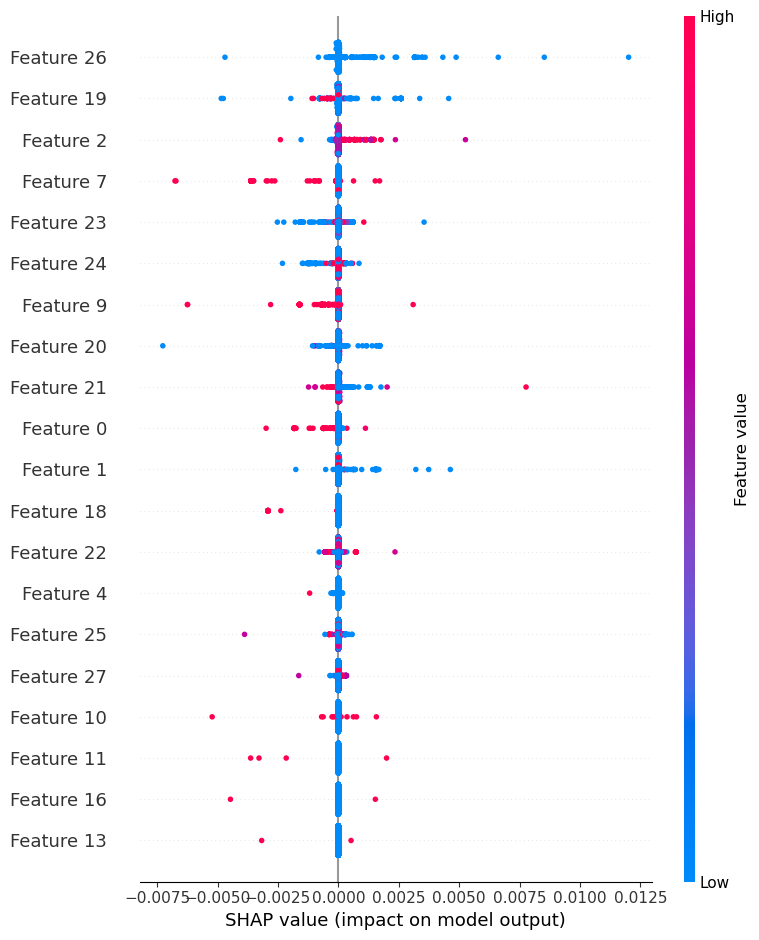

In [122]:
# Generate SHAP values for a sample of the clean test data
shap_values_mean = shap_values_clean.mean(axis=2)  # Average across classes
shap.summary_plot(shap_values_mean, X_test_small, plot_type="dot", title="SHAP Beeswarm Plot - Mean across Classes")


In [59]:
shap_values_fgsm = explainer.shap_values(X_test_adversarial_fgsm) 
print("Shape of shap_values_fgsm:", np.array(shap_values_fgsm).shape)
print("Shape of X_test_adversarial_fgsm:", X_test_adversarial_fgsm.shape)


Shape of shap_values_fgsm: (22543, 28, 40)
Shape of X_test_adversarial_fgsm: (22543, 28)


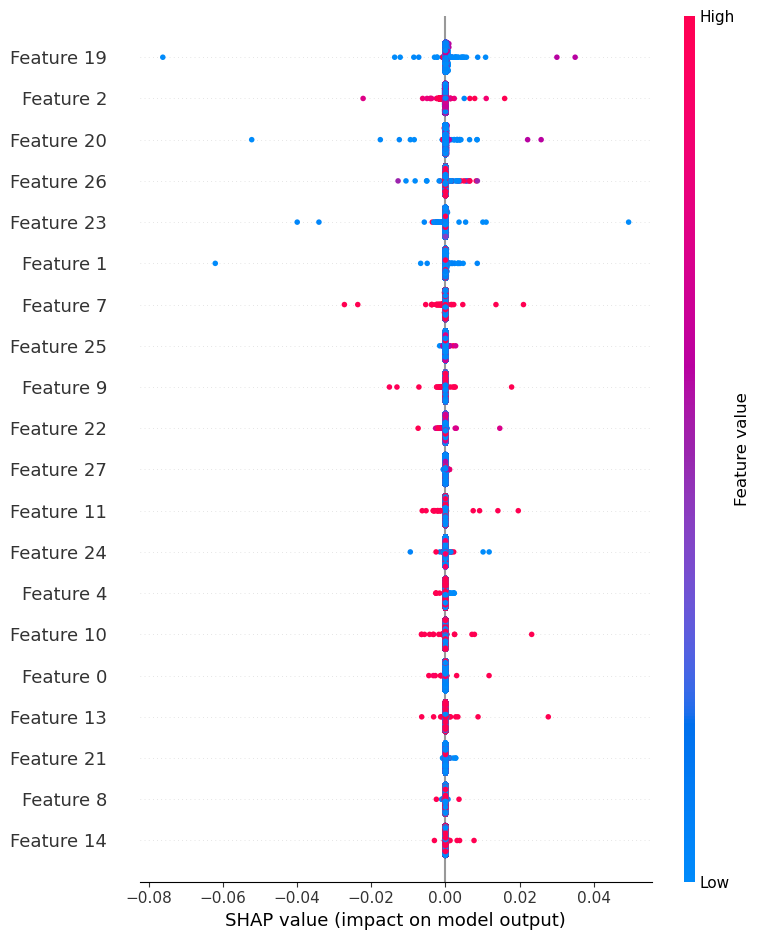

In [61]:
shap_values_fgsm_mean = shap_values_fgsm.mean(axis=2)
shap.summary_plot(shap_values_fgsm_mean, X_test_adversarial_fgsm, plot_type="dot", title="SHAP Summary for FGSM Adversarial Data - Mean across Classes")


In [67]:
shap_values_pgd = explainer.shap_values(X_test_adversarial) 
print("Shape of shap_values_fgsm:", np.array(shap_values_pgd).shape)
print("Shape of X_test_adversarial_fgsm:", X_test_adversarial.shape)


Shape of shap_values_fgsm: (22543, 28, 40)
Shape of X_test_adversarial_fgsm: (22543, 28)


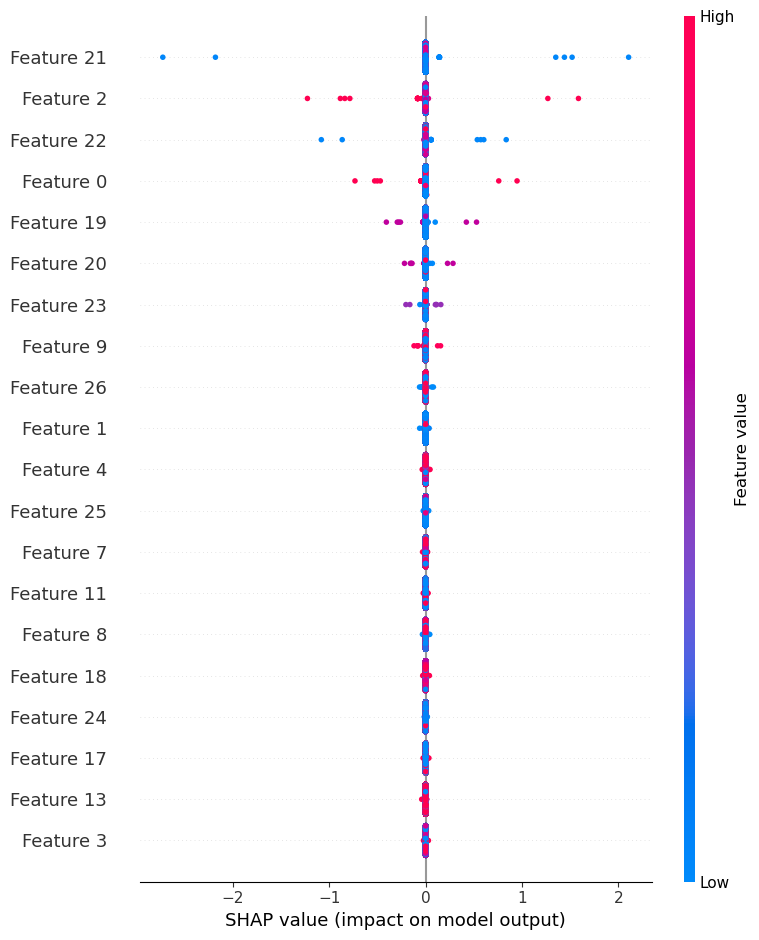

In [75]:
shap_values_pgd_mean = shap_values_pgd.mean(axis=2)
shap.summary_plot(shap_values_pgd_mean, X_test_adversarial, plot_type="dot", title="SHAP Summary for PGD Adversarial Data - Mean across Classes")


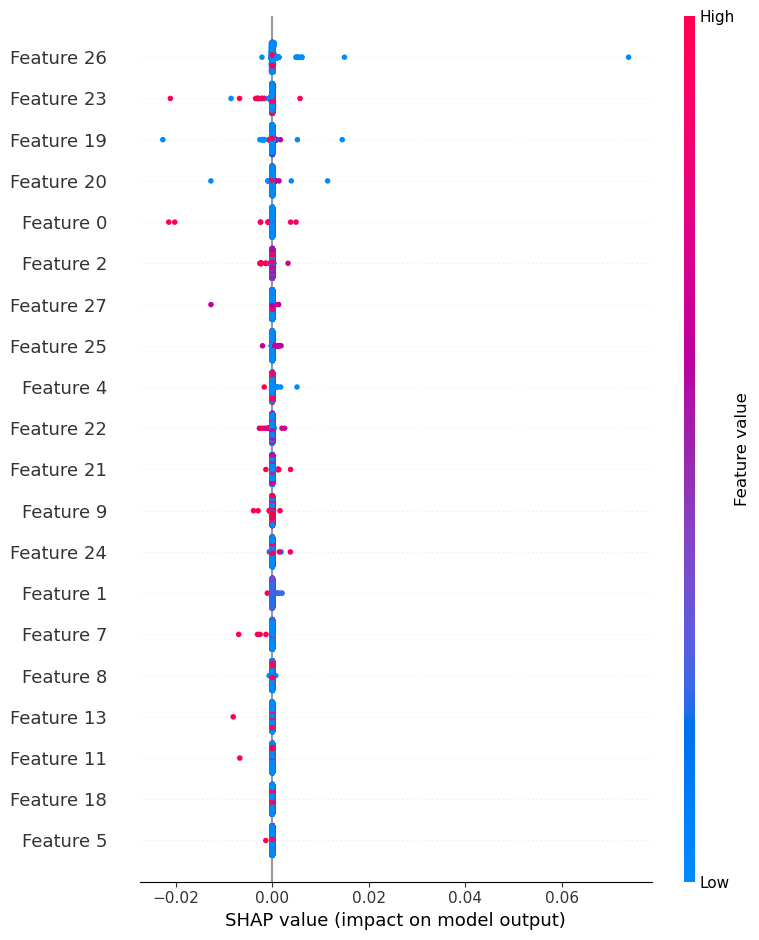

In [77]:
shap_values_cw = explainer.shap_values(X_test_cw)  
shap_values_cw_mean = shap_values_cw.mean(axis=2)
shap.summary_plot(shap_values_cw_mean, X_test_cw, plot_type="dot", title="SHAP Summary for Carlini & Wagner Adversarial Data")


In [52]:
print("Data types in X_train before scaling:")
print(X_train.dtypes)


Data types in X_train before scaling:
0         int64
tcp       int64
0.1       int64
0.2       int64
0.3       int64
0.4       int64
0.5       int64
0.6       int64
0.7       int64
0.8       int64
0.9       int64
0.10      int64
0.11      int64
0.12      int64
0.13      int64
0.14      int64
0.15      int64
0.16      int64
0.18      int64
0.19    float64
0.20    float64
0.21    float64
0.22    float64
1       float64
0.23    float64
0.24    float64
0.17    float64
0.25    float64
dtype: object


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Assume X_train and y_train are your training data (features and labels), already preprocessed
# Assume X_test and y_test are your test data (features and labels), already preprocessed

# Step 1: Scale the Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.preprocessing import QuantileTransformer

# Apply QuantileTransformer to transform features to a normal distribution
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = quantile_transformer.fit_transform(X_train)
X_test_scaled = quantile_transformer.transform(X_test)

from sklearn.preprocessing import LabelEncoder
import numpy as np

# Concatenate y_train and y_test to include all labels
all_labels = np.concatenate([y_train, y_test])

# Fit LabelEncoder on the combined labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Transform y_train and y_test using the fitted encoder
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(np.unique(all_labels))  # Total number of unique classes in y_train and y_test
print("Number of unique classes:", num_classes)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Redefine the model with the correct number of classes
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Ensure output layer matches the number of unique classes
])

# Compile the model
mlp_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Step 4: Train the Model
history = mlp_model.fit(X_train_scaled, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test_scaled, y_test_encoded))


Number of unique classes: 40
Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 463us/step - accuracy: 0.9317 - loss: 0.2606 - val_accuracy: 0.1699 - val_loss: 5.0135
Epoch 2/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 420us/step - accuracy: 0.9666 - loss: 0.0959 - val_accuracy: 0.3359 - val_loss: 5.3930
Epoch 3/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 430us/step - accuracy: 0.9678 - loss: 0.0889 - val_accuracy: 0.1510 - val_loss: 6.5614
Epoch 4/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 437us/step - accuracy: 0.9707 - loss: 0.0818 - val_accuracy: 0.1130 - val_loss: 7.4223
Epoch 5/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 428us/step - accuracy: 0.9733 - loss: 0.0763 - val_accuracy: 0.2960 - val_loss: 7.0540
Epoch 6/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 471us/step - accuracy: 0.9752 - loss: 0.0713 - val_accuracy: 0.1327 - val_loss: 9.7562
Epoch 7/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 449us/step - accuracy: 0.9767 - loss: 0.0662 - val_accuracy: 0.3366 - val_loss: 9.2403
Epoch 8/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 2s 425us/step - accuracy: 0.9787 - loss: 0.06

In [14]:
# Evaluate the MLP model on clean data using encoded labels for y_test
y_pred = mlp_model.predict(X_test_scaled).argmax(axis=1)
clean_accuracy = accuracy_score(y_test_encoded, y_pred)
clean_class_report = classification_report(y_test_encoded, y_pred, zero_division=1)
clean_conf_matrix = confusion_matrix(y_test_encoded, y_pred)
# Decode the integer labels back to the original class names
y_test_labels = label_encoder.inverse_transform(y_test_encoded)
y_pred_labels = label_encoder.inverse_transform(y_pred)
from sklearn.metrics import classification_report, confusion_matrix

# Generate the classification report with the original attack names
decoded_class_report = classification_report(y_test_labels, y_pred_labels, zero_division=1)
decoded_conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
print("MLP Model Accuracy on Clean Data:", clean_accuracy)
print("Classification Report on Clean Data with Attack Names:\n", decoded_class_report)
print("\nConfusion Matrix on Clean Data with Attack Names:\n", decoded_conf_matrix)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step
MLP Model Accuracy on Clean Data: 0.38956660604178683
Classification Report on Clean Data with Attack Names:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       1.00      0.00      0.00       359
buffer_overflow       1.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       1.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          named       1.00      0.00      0.00  

In [16]:
from art.estimators.classification import TensorFlowV2Classifier
import tensorflow as tf

# Wrap the MLP model in an ART classifier
classifier = TensorFlowV2Classifier(
    model=mlp_model,
    nb_classes=len(label_encoder.classes_),  # Total number of classes
    input_shape=(X_train_scaled.shape[1],),  # Shape of input features
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy()
)


/opt/anaconda3/lib/python3.11/site-packages/art/estimators/certification/__init__.py:30: UserWarning: PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality
  warnings.warn("PyTorch not found. Not importing DeepZ or Interval Bound Propagation functionality")


In [18]:
from art.attacks.evasion import FastGradientMethod

# Configure the FGSM attack
epsilon = 0.1  # You can experiment with different values
fgsm_attack = FastGradientMethod(estimator=classifier, eps=epsilon)

# Generate adversarial examples on the test set
X_test_fgsm = fgsm_attack.generate(x=X_test_scaled)


In [20]:
# Predict on the FGSM adversarial examples
y_pred_fgsm = mlp_model.predict(X_test_fgsm).argmax(axis=1)

# Decode the predicted labels for interpretability
y_pred_fgsm_labels = label_encoder.inverse_transform(y_pred_fgsm)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Calculate accuracy and generate the classification report
fgsm_accuracy = accuracy_score(y_test_labels, y_pred_fgsm_labels)
fgsm_class_report = classification_report(y_test_labels, y_pred_fgsm_labels, zero_division=1)
fgsm_conf_matrix = confusion_matrix(y_test_labels, y_pred_fgsm_labels)

print("MLP Model Accuracy on FGSM Adversarial Examples:", fgsm_accuracy)
print("\nClassification Report on FGSM Adversarial Examples:\n", fgsm_class_report)
print("\nConfusion Matrix on FGSM Adversarial Examples:\n", fgsm_conf_matrix)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
MLP Model Accuracy on FGSM Adversarial Examples: 0.3821141817859202

Classification Report on FGSM Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       1.00      0.00      0.00       359
buffer_overflow       1.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       0.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       1.00      0.00

In [22]:
from art.attacks.evasion import ProjectedGradientDescent

# Configure PGD attack parameters
epsilon = 0.1         # Maximum perturbation
eps_step = 0.01       # Step size per iteration
max_iter = 40         # Number of iterations

# Create the PGD attack
pgd_attack = ProjectedGradientDescent(
    estimator=classifier, 
    eps=epsilon, 
    eps_step=eps_step, 
    max_iter=max_iter
)

# Generate adversarial examples on the test set
X_test_pgd = pgd_attack.generate(x=X_test_scaled)


PGD - Batches: 0it [00:00, ?it/s]

2024-11-06 19:03:34.279244: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [24]:
# Predict on the PGD adversarial examples
y_pred_pgd = mlp_model.predict(X_test_pgd).argmax(axis=1)

# Decode the predicted labels for interpretability
y_pred_pgd_labels = label_encoder.inverse_transform(y_pred_pgd)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Calculate accuracy and generate the classification report
pgd_accuracy = accuracy_score(y_test_labels, y_pred_pgd_labels)
pgd_class_report = classification_report(y_test_labels, y_pred_pgd_labels, zero_division=1)
pgd_conf_matrix = confusion_matrix(y_test_labels, y_pred_pgd_labels)

print("MLP Model Accuracy on PGD Adversarial Examples:", pgd_accuracy)
print("\nClassification Report on PGD Adversarial Examples:\n", pgd_class_report)
print("\nConfusion Matrix on PGD Adversarial Examples:\n", pgd_conf_matrix)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step
MLP Model Accuracy on PGD Adversarial Examples: 0.3778112939715211

Classification Report on PGD Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       1.00      0.00      0.00       359
buffer_overflow       1.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       0.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       0.00      0.00      0.00        18
          named       1.00      0.00  

In [26]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Select a random sample (e.g., 10%) of the test data
sample_size = int(0.1 * len(X_test_scaled))  # Adjust to fit your available test data
indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

# Create the smaller subset
X_test_small = X_test_scaled[indices]
y_test_small = y_test_encoded[indices]



In [28]:
from art.attacks.evasion import CarliniL2Method

# Configure the Carlini & Wagner attack
cw_attack = CarliniL2Method(
    classifier=classifier,
    confidence=0.1,   # Set desired confidence level
    max_iter=10,      # Number of optimization iterations; increase for stronger attacks
    batch_size=32     # Batch size for processing
)

# Generate adversarial examples on the smaller subset
X_test_cw = cw_attack.generate(x=X_test_small)


C&W L_2:   0%|          | 0/71 [00:00<?, ?it/s]

In [38]:
# Predict on the C&W adversarial examples
y_pred_cw = mlp_model.predict(X_test_cw).argmax(axis=1)

# Decode the predicted and true labels for interpretability
y_pred_cw_labels = label_encoder.inverse_transform(y_pred_cw)
y_test_small_labels = label_encoder.inverse_transform(y_test_small)

# Calculate accuracy and generate the classification report
cw_accuracy = accuracy_score(y_test_small_labels, y_pred_cw_labels)
cw_class_report = classification_report(y_test_small_labels, y_pred_cw_labels, zero_division=1)
cw_conf_matrix = confusion_matrix(y_test_small_labels, y_pred_cw_labels)

print("MLP Model Accuracy on Carlini & Wagner Adversarial Examples:", cw_accuracy)
print("\nClassification Report on Carlini & Wagner Adversarial Examples:\n", cw_class_report)


71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step
MLP Model Accuracy on Carlini & Wagner Adversarial Examples: 0.42014196983141083

Classification Report on Carlini & Wagner Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00        84
           back       1.00      0.00      0.00        43
buffer_overflow       1.00      0.00      0.00         1
   guess_passwd       1.00      0.00      0.00       143
     httptunnel       1.00      0.00      0.00        12
        ipsweep       0.00      0.00      0.00         9
           land       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00        24
          mscan       1.00      0.00      0.00       107
       multihop       0.00      0.00      0.00         1
          named       1.00      0.00      0.00         2
        neptune       0.38      0.30      0.34       437
           nmap       0.00      0.00      0.00        10
         norm

In [55]:
import shap
import numpy as np

# Select a subset of the training data for SHAP background data
background_data = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]

# Initialize the SHAP DeepExplainer with the trained MLP model and background data
explainer = shap.DeepExplainer(mlp_model, background_data)


/opt/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")
/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


In [74]:
import numpy as np

# Define the sample size
sample_size = 100

# Generate a random sample of indices for each dataset
sample_indices_test = np.random.choice(X_test_scaled.shape[0], sample_size, replace=False)
sample_indices_fgsm = np.random.choice(X_test_fgsm.shape[0], sample_size, replace=False)
sample_indices_pgd = np.random.choice(X_test_pgd.shape[0], sample_size, replace=False)
sample_indices_cw = np.random.choice(X_test_cw.shape[0], sample_size, replace=False)

# Use the sampled indices to subset each dataset
X_test_sample = X_test_scaled[sample_indices_test]
X_test_fgsm_sample = X_test_fgsm[sample_indices_fgsm]
X_test_pgd_sample = X_test_pgd[sample_indices_pgd]
X_test_cw_sample = X_test_cw[sample_indices_cw]

# Now you can proceed with SHAP calculations on these subsets

# Generate SHAP values
shap_values_clean = explainer.shap_values(X_test_sample)
shap_values_fgsm = explainer.shap_values(X_test_fgsm_sample)
shap_values_pgd = explainer.shap_values(X_test_pgd_sample)
shap_values_cw = explainer.shap_values(X_test_cw_sample)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


Adjusted Shape of SHAP values (shap_values_clean_mean): (100, 28)
Shape of X_test_sample: (100, 28)


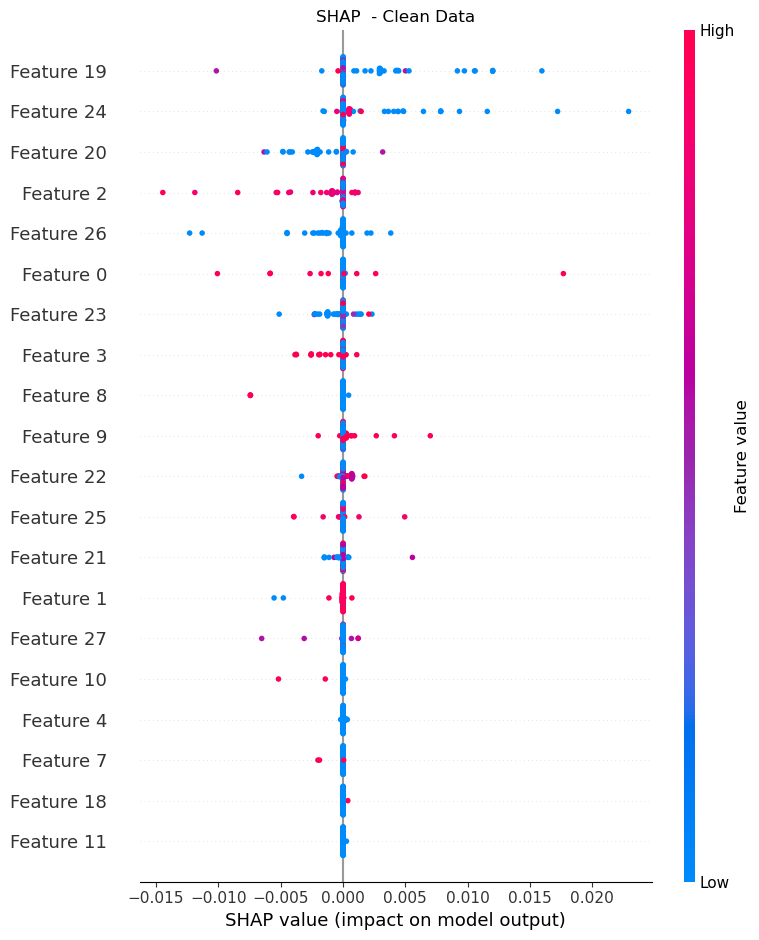

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure sample size is correctly applied to both SHAP values and the data
sample_size = X_test_sample.shape[0]  # Should be 100

# Recompute SHAP values for the clean dataset subset with the correct sample size
# Avoid any premature averaging or class selection
shap_values_clean = explainer.shap_values(X_test_sample)

# If shap_values_clean has an extra dimension, reduce it by averaging or selecting a class
if len(shap_values_clean.shape) == 3:
    # Option A: Average over classes
    shap_values_clean_mean = np.mean(shap_values_clean, axis=-1)  # Result: (sample_size, num_features)

    # Alternatively, Option B: Select a specific class if required (e.g., class 0)
    # shap_values_clean_mean = shap_values_clean[:, :, 0]

# Check the shapes for final confirmation
print("Adjusted Shape of SHAP values (shap_values_clean_mean):", shap_values_clean_mean.shape)
print("Shape of X_test_sample:", X_test_sample.shape)

# Plot the SHAP summary plot with adjusted shapes
plt.figure(figsize=(10, 6))
plt.title("SHAP  - Clean Data")
shap.summary_plot(shap_values_clean_mean, X_test_sample, plot_type="dot")



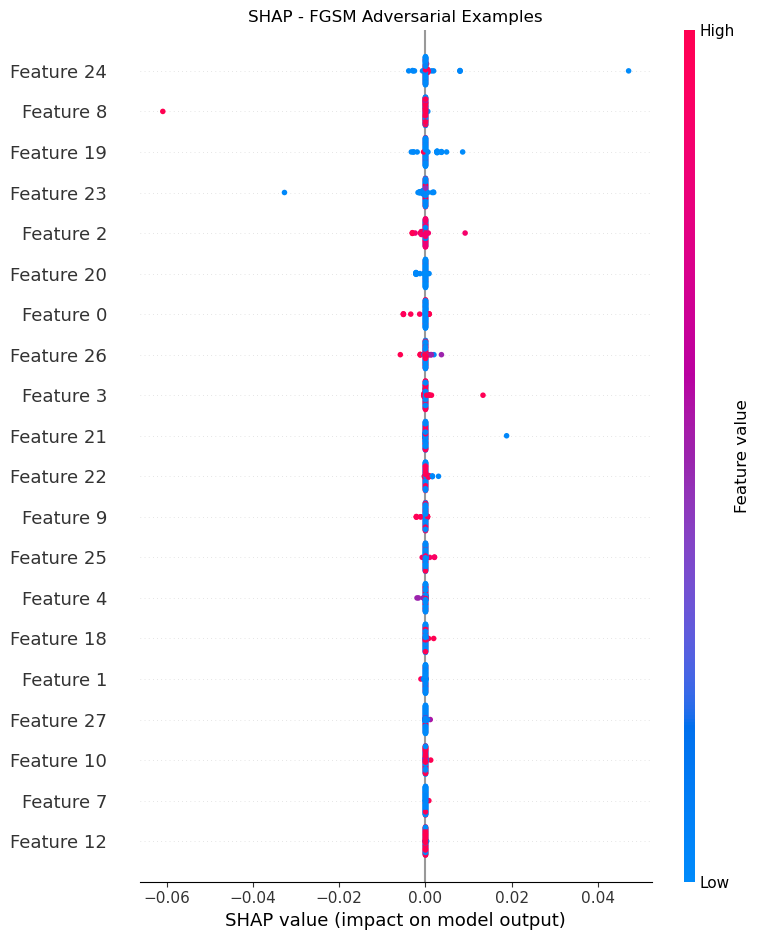

In [90]:
def adjust_shap_values(shap_values):
    # If SHAP values have a third dimension, average over it
    if len(shap_values.shape) == 3:
        shap_values = shap_values.mean(axis=-1)  # Average across classes if multi-class
    return shap_values
# 2. FGSM Adversarial Examples SHAP Summary Plot
shap_values_fgsm_mean = adjust_shap_values(np.array(shap_values_fgsm))

plt.figure(figsize=(10, 6))
plt.title("SHAP - FGSM Adversarial Examples")
shap.summary_plot(shap_values_fgsm_mean, X_test_fgsm_sample, plot_type="dot")


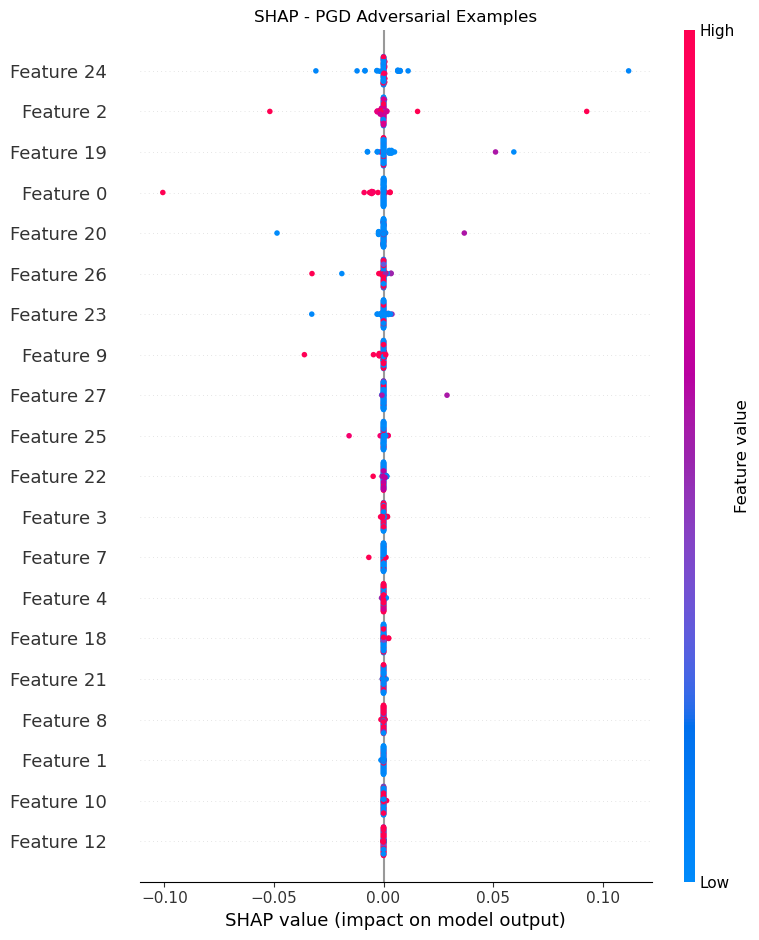

In [92]:
def adjust_shap_values(shap_values):
    # If SHAP values have a third dimension, average over it
    if len(shap_values.shape) == 3:
        shap_values = shap_values.mean(axis=-1)  # Average across classes if multi-class
    return shap_values

# 3. PGD Adversarial Examples SHAP Summary Plot
shap_values_pgd_mean = adjust_shap_values(np.array(shap_values_pgd))

plt.figure(figsize=(10, 6))
plt.title("SHAP - PGD Adversarial Examples")
shap.summary_plot(shap_values_pgd_mean, X_test_pgd_sample, plot_type="dot")



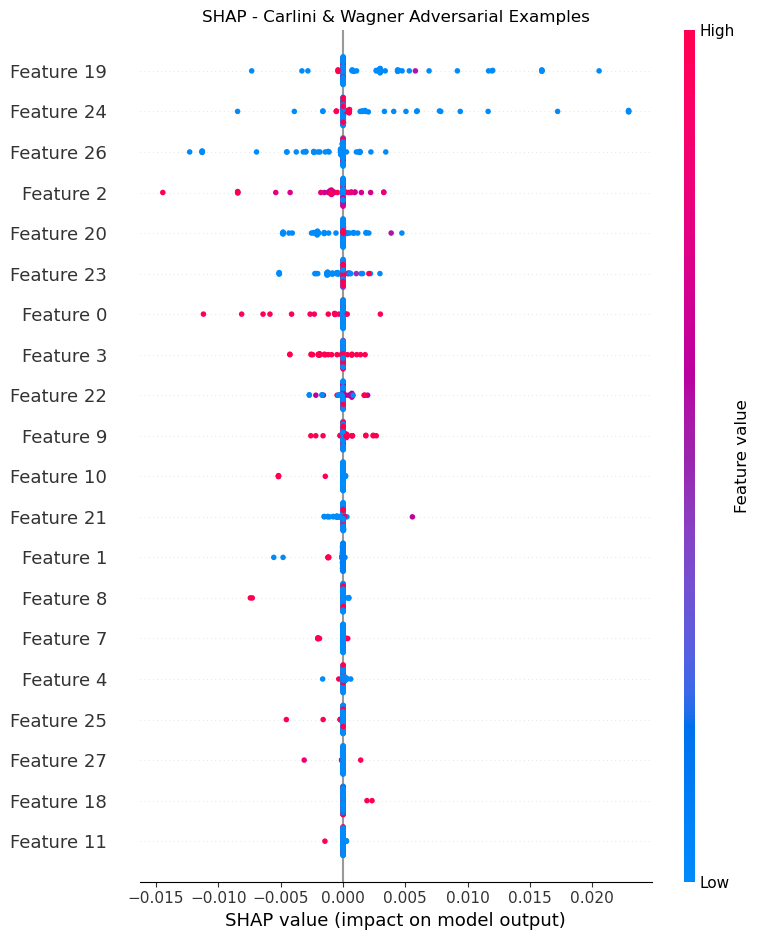

In [94]:
def adjust_shap_values(shap_values):
    # If SHAP values have a third dimension, average over it
    if len(shap_values.shape) == 3:
        shap_values = shap_values.mean(axis=-1)  # Average across classes if multi-class
    return shap_values
# 4. C&W Adversarial Examples SHAP Summary Plot
shap_values_cw_mean = adjust_shap_values(np.array(shap_values_cw))  # Average across classes

plt.figure(figsize=(10, 6))
plt.title("SHAP - Carlini & Wagner Adversarial Examples")
shap.summary_plot(shap_values_cw_mean, X_test_cw_sample, plot_type="dot")


In [14]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Combine y_train and y_test to fit the encoder on all labels
all_labels = pd.concat([y_train, y_test], axis=0)
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Encode the labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Verify the number of classes
num_classes = len(label_encoder.classes_)
print("Total number of classes:", num_classes)



Total number of classes: 40


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

# Reshape data for 1D CNN input
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_cnn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define a 1D CNN model for tabular data
cnn_model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.25),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Output layer for 40 classes
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = cnn_model.fit(X_train_cnn, y_train_encoded, epochs=30, batch_size=32, validation_data=(X_test_cnn, y_test_encoded))


Epoch 1/30


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3937/3937 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8736 - loss: 0.4735 - val_accuracy: 0.4977 - val_loss: 5.9305
Epoch 2/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9407 - loss: 0.1851 - val_accuracy: 0.4814 - val_loss: 6.7889
Epoch 3/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9441 - loss: 0.1681 - val_accuracy: 0.4814 - val_loss: 8.1083
Epoch 4/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9461 - loss: 0.1579 - val_accuracy: 0.4853 - val_loss: 8.8767
Epoch 5/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9468 - loss: 0.1516 - val_accuracy: 0.4810 - val_loss: 10.1934
Epoch 6/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9473 - loss: 0.1502 - val_accuracy: 0.4805 - val_loss: 10.3361
Epoch 7/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9482 - loss: 0.1471 - val_accuracy: 0.4769 - val_loss: 11.8950
Epoch 8/30
3937/3937 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9471 - loss: 0.1495 - val_accu

In [24]:
from sklearn.metrics import classification_report

# Predict the labels for the test set
y_pred_cnn = cnn_model.predict(X_test_cnn).argmax(axis=1)
# Decode the predictions back to original labels
y_pred_decoded = label_encoder.inverse_transform(y_pred_cnn)
y_test_decoded = label_encoder.inverse_transform(y_test_encoded)
# Generate the classification report
cnn_class_report = classification_report(y_test_decoded, y_pred_decoded, zero_division=1)
print("Classification Report for CNN Model on Test Data:\n", cnn_class_report)


705/705 ━━━━━━━━━━━━━━━━━━━━ 0s 463us/step
Classification Report for CNN Model on Test Data:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       1.00      0.00      0.00       359
buffer_overflow       1.00      0.00      0.00        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       1.00      0.00      0.00       141
           land       1.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          named       1.00      0.00      0.00        17
        neptune       0.62      0.31      0.42    

In [26]:
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Convert the model to a TensorFlowV2Classifier
cnn_classifier = TensorFlowV2Classifier(
    model=cnn_model,
    nb_classes=num_classes,
    input_shape=(X_train_cnn.shape[1], 1),
    loss_object=tf.keras.losses.SparseCategoricalCrossentropy(),
    clip_values=(X_train_cnn.min(), X_train_cnn.max())
)

# Configure the FGSM attack
fgsm_attack = FastGradientMethod(estimator=cnn_classifier, eps=0.1)  # Adjust `eps` as needed

# Generate adversarial examples
X_test_fgsm = fgsm_attack.generate(x=X_test_cnn)


# Evaluate model performance on adversarial examples
y_pred_fgsm = cnn_classifier.predict(X_test_fgsm).argmax(axis=1)
fgsm_accuracy = accuracy_score(y_test_encoded, y_pred_fgsm)
fgsm_class_report = classification_report(y_test_encoded, y_pred_fgsm, zero_division=1)

# Decode the predicted labels for interpretability
y_pred_fgsm_labels = label_encoder.inverse_transform(y_pred_fgsm)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Calculate accuracy and generate the classification report
fgsm_accuracy = accuracy_score(y_test_labels, y_pred_fgsm_labels)
fgsm_class_report = classification_report(y_test_labels, y_pred_fgsm_labels, zero_division=1)
fgsm_conf_matrix = confusion_matrix(y_test_labels, y_pred_fgsm_labels)


print("CNN Model Accuracy on FGSM Adversarial Examples:", fgsm_accuracy)
print("\nClassification Report on FGSM Adversarial Examples:\n", fgsm_class_report)


CNN Model Accuracy on FGSM Adversarial Examples: 0.48139111919442845

Classification Report on FGSM Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       1.00      0.00      0.00       359
buffer_overflow       0.50      0.10      0.17        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       1.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          named       1.00      0.00      0.00        17
        neptune      

In [32]:
from art.attacks.evasion import ProjectedGradientDescent

# Configure PGD attack parameters
epsilon = 0.1         # Maximum perturbation
eps_step = 0.01       # Step size per iteration
max_iter = 40         # Number of iterations

# Create the PGD attack
pgd_attack = ProjectedGradientDescent(
    estimator=cnn_classifier, 
    eps=epsilon, 
    eps_step=eps_step, 
    max_iter=max_iter
)

# Generate adversarial examples on the test set
X_test_pgd = pgd_attack.generate(x=X_test_scaled)

PGD - Batches: 0it [00:00, ?it/s]

2024-11-06 17:38:09.542331: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [34]:
# Predict on the PGD adversarial examples
y_pred_pgd = cnn_model.predict(X_test_pgd).argmax(axis=1)

# Decode the predicted labels for interpretability
y_pred_pgd_labels = label_encoder.inverse_transform(y_pred_pgd)
y_test_labels = label_encoder.inverse_transform(y_test_encoded)

# Calculate accuracy and generate the classification report
pgd_accuracy = accuracy_score(y_test_labels, y_pred_pgd_labels)
pgd_class_report = classification_report(y_test_labels, y_pred_pgd_labels, zero_division=1)
pgd_conf_matrix = confusion_matrix(y_test_labels, y_pred_pgd_labels)

print("CNN Model Accuracy on PGD Adversarial Examples:", pgd_accuracy)
print("\nClassification Report on PGD Adversarial Examples:\n", pgd_class_report)


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step
CNN Model Accuracy on PGD Adversarial Examples: 0.48108060151710064

Classification Report on PGD Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00       737
           back       1.00      0.00      0.00       359
buffer_overflow       0.50      0.10      0.17        20
      ftp_write       1.00      0.00      0.00         3
   guess_passwd       1.00      0.00      0.00      1231
     httptunnel       1.00      0.00      0.00       133
           imap       1.00      0.00      0.00         1
        ipsweep       0.00      0.00      0.00       141
           land       1.00      0.00      0.00         7
     loadmodule       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00       293
          mscan       1.00      0.00      0.00       996
       multihop       1.00      0.00      0.00        18
          named       1.00      0.00 

In [36]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Select a random sample (e.g., 10%) of the test data
sample_size = int(0.1 * len(X_test_scaled))  # Adjust to fit your available test data
indices = np.random.choice(len(X_test_scaled), sample_size, replace=False)

# Create the smaller subset
X_test_small = X_test_scaled[indices]
y_test_small = y_test_encoded[indices]



In [40]:
from art.attacks.evasion import CarliniL2Method

# Configure the Carlini & Wagner attack
cw_attack = CarliniL2Method(
    classifier=cnn_classifier,
    confidence=0.1,   # Set desired confidence level
    max_iter=10,      # Number of optimization iterations; increase for stronger attacks
    batch_size=32     # Batch size for processing
)

# Generate adversarial examples on the smaller subset
X_test_cw = cw_attack.generate(x=X_test_small)


C&W L_2:   0%|          | 0/71 [00:00<?, ?it/s]

In [46]:
# Predict on the C&W adversarial examples
y_pred_cw = cnn_model.predict(X_test_cw).argmax(axis=1)

# Decode the predicted and true labels for interpretability
y_pred_cw_labels = label_encoder.inverse_transform(y_pred_cw)
y_test_small_labels = label_encoder.inverse_transform(y_test_small)

# Calculate accuracy and generate the classification report
cw_accuracy = accuracy_score(y_test_small_labels, y_pred_cw_labels)
cw_class_report = classification_report(y_test_small_labels, y_pred_cw_labels, zero_division=1)
cw_conf_matrix = confusion_matrix(y_test_small_labels, y_pred_cw_labels)

print("CNN Model Accuracy on Carlini & Wagner Adversarial Examples:", cw_accuracy)
print("\nClassification Report on Carlini & Wagner Adversarial Examples:\n", cw_class_report)



71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step
CNN Model Accuracy on Carlini & Wagner Adversarial Examples: 0.45607808340727596

Classification Report on Carlini & Wagner Adversarial Examples:
                  precision    recall  f1-score   support

        apache2       1.00      0.00      0.00        84
           back       1.00      0.00      0.00        43
buffer_overflow       1.00      0.00      0.00         1
   guess_passwd       1.00      0.00      0.00       143
     httptunnel       1.00      0.00      0.00        12
        ipsweep       0.00      0.00      0.00         9
           land       1.00      0.00      0.00         2
       mailbomb       1.00      0.00      0.00        24
          mscan       1.00      0.00      0.00       107
       multihop       1.00      0.00      0.00         1
          named       1.00      0.00      0.00         2
        neptune       0.55      0.33      0.41       437
           nmap       1.00      0.00      0.00        10
         norm

In [80]:
import numpy as np

# Check and print the shape of the CNN model input
print("Expected CNN Model Input Shape:", cnn_model.input_shape)

# Step 1: Prepare and check background data shape
background_data_cnn = X_train_scaled[np.random.choice(X_train_scaled.shape[0], 100, replace=False)]
print("Original Background Data Shape:", background_data_cnn.shape)

# Ensure background_data_cnn has the shape (sample_size, 28, 1)
if background_data_cnn.shape[1:] != (28, 1):
    background_data_cnn = background_data_cnn.reshape(-1, 28, 1)

print("Reshaped Background Data Shape:", background_data_cnn.shape)

# Step 2: Define sample size and generate separate sample indices for each dataset
sample_size = 100
sample_indices_cnn = np.random.choice(X_test_cnn.shape[0], sample_size, replace=False)
sample_indices_fgsm = np.random.choice(X_test_fgsm.shape[0], sample_size, replace=False)
sample_indices_pgd = np.random.choice(X_test_pgd.shape[0], sample_size, replace=False)
sample_indices_cw = np.random.choice(X_test_cw.shape[0], sample_size, replace=False)

# Subset and reshape each dataset, and print out the shape of each
X_test_cnn_sample = X_test_cnn[sample_indices_cnn]
X_test_fgsm_sample = X_test_fgsm[sample_indices_fgsm]
X_test_pgd_sample = X_test_pgd[sample_indices_pgd]
X_test_cw_sample = X_test_cw[sample_indices_cw]

print("Original X_test_cnn_sample Shape:", X_test_cnn_sample.shape)
print("Original X_test_fgsm_sample Shape:", X_test_fgsm_sample.shape)
print("Original X_test_pgd_sample Shape:", X_test_pgd_sample.shape)
print("Original X_test_cw_sample Shape:", X_test_cw_sample.shape)

# Ensure each test dataset sample has shape (sample_size, 28, 1)
if X_test_cnn_sample.shape[1:] != (28, 1):
    X_test_cnn_sample = X_test_cnn_sample.reshape(-1, 28, 1)
if X_test_fgsm_sample.shape[1:] != (28, 1):
    X_test_fgsm_sample = X_test_fgsm_sample.reshape(-1, 28, 1)
if X_test_pgd_sample.shape[1:] != (28, 1):
    X_test_pgd_sample = X_test_pgd_sample.reshape(-1, 28, 1)
if X_test_cw_sample.shape[1:] != (28, 1):
    X_test_cw_sample = X_test_cw_sample.reshape(-1, 28, 1)

# Print the shapes again after reshaping
print("Reshaped X_test_cnn_sample Shape:", X_test_cnn_sample.shape)
print("Reshaped X_test_fgsm_sample Shape:", X_test_fgsm_sample.shape)
print("Reshaped X_test_pgd_sample Shape:", X_test_pgd_sample.shape)
print("Reshaped X_test_cw_sample Shape:", X_test_cw_sample.shape)

shap_values_clean_cnn = explainer_cnn.shap_values(X_test_cnn_sample)
shap_values_fgsm_cnn = explainer_cnn.shap_values(X_test_fgsm_sample)
shap_values_pgd_cnn = explainer_cnn.shap_values(X_test_pgd_sample)
shap_values_cw_cnn = explainer_cnn.shap_values(X_test_cw_sample)


Expected CNN Model Input Shape: (None, 28, 1)
Original Background Data Shape: (100, 28)
Reshaped Background Data Shape: (100, 28, 1)
Original X_test_cnn_sample Shape: (100, 28, 1)
Original X_test_fgsm_sample Shape: (100, 28, 1)
Original X_test_pgd_sample Shape: (100, 28)
Original X_test_cw_sample Shape: (100, 28)
Reshaped X_test_cnn_sample Shape: (100, 28, 1)
Reshaped X_test_fgsm_sample Shape: (100, 28, 1)
Reshaped X_test_pgd_sample Shape: (100, 28, 1)
Reshaped X_test_cw_sample Shape: (100, 28, 1)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


In [106]:
# Set correct sample size to avoid previous errors
sample_size = 40  # Adjust to align with data as needed; initially using a manageable subset
X_test_cnn_sample = X_test_cnn_sample[:sample_size]
X_test_fgsm_sample = X_test_fgsm_sample[:sample_size]
X_test_pgd_sample = X_test_pgd_sample[:sample_size]
X_test_cw_sample = X_test_cw_sample[:sample_size]

# Recompute SHAP values, selecting the class if necessary
shap_values_clean_cnn = explainer_cnn.shap_values(X_test_cnn_sample)[0]
shap_values_fgsm_cnn = explainer_cnn.shap_values(X_test_fgsm_sample)[0]
shap_values_pgd_cnn = explainer_cnn.shap_values(X_test_pgd_sample)[0]
shap_values_cw_cnn = explainer_cnn.shap_values(X_test_cw_sample)[0]

# Adjust and verify shapes for alignment
shap_values_clean_cnn = shap_values_clean_cnn.reshape(sample_size, 28)
shap_values_fgsm_cnn = shap_values_fgsm_cnn.reshape(sample_size, 28)
shap_values_pgd_cnn = shap_values_pgd_cnn.reshape(sample_size, 28)
shap_values_cw_cnn = shap_values_cw_cnn.reshape(sample_size, 28)

X_test_cnn_sample_reduced = X_test_cnn_sample.reshape(sample_size, 28)
X_test_fgsm_sample_reduced = X_test_fgsm_sample.reshape(sample_size, 28)
X_test_pgd_sample_reduced = X_test_pgd_sample.reshape(sample_size, 28)
X_test_cw_sample_reduced = X_test_cw_sample.reshape(sample_size, 28)


/opt/anaconda3/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor. Received: the structure of inputs=['*']
  warnings.warn(


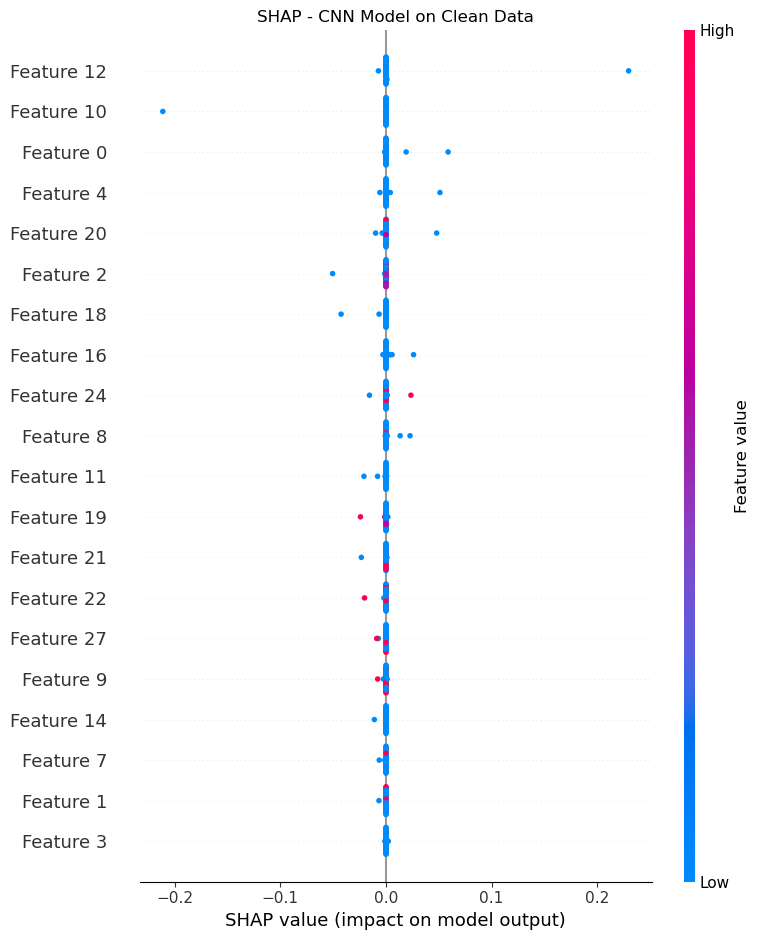

In [113]:
# Plot SHAP Beeswarm Plots
plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on Clean Data")
shap.summary_plot(shap_values_clean_cnn, X_test_cnn_sample_reduced, plot_type="dot")

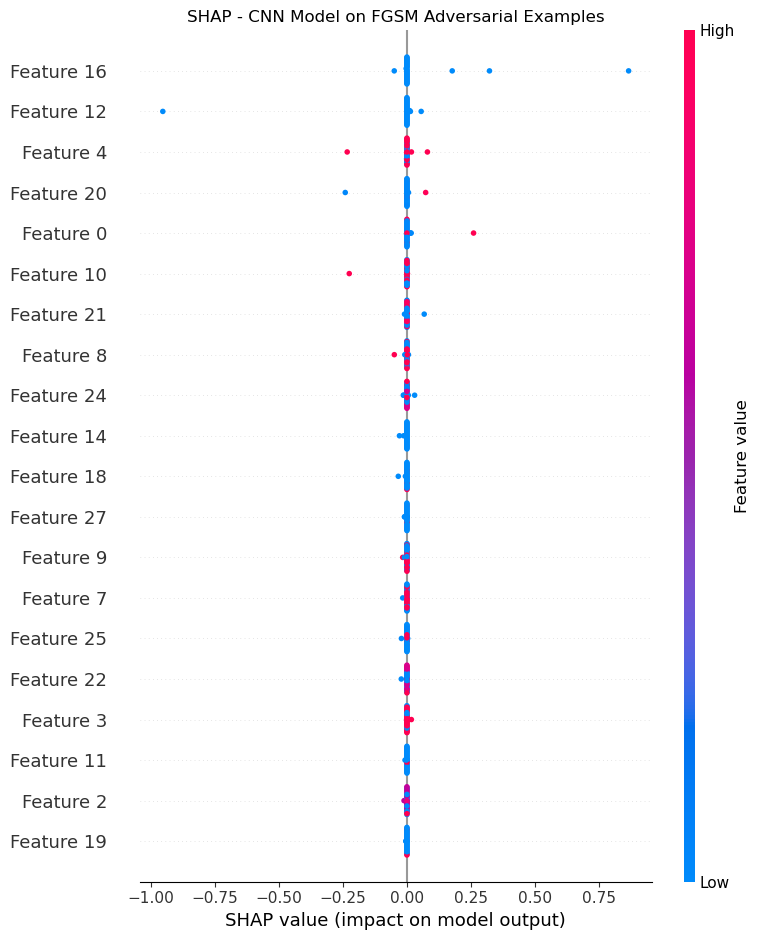

In [115]:

plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on FGSM Adversarial Examples")
shap.summary_plot(shap_values_fgsm_cnn, X_test_fgsm_sample_reduced, plot_type="dot")


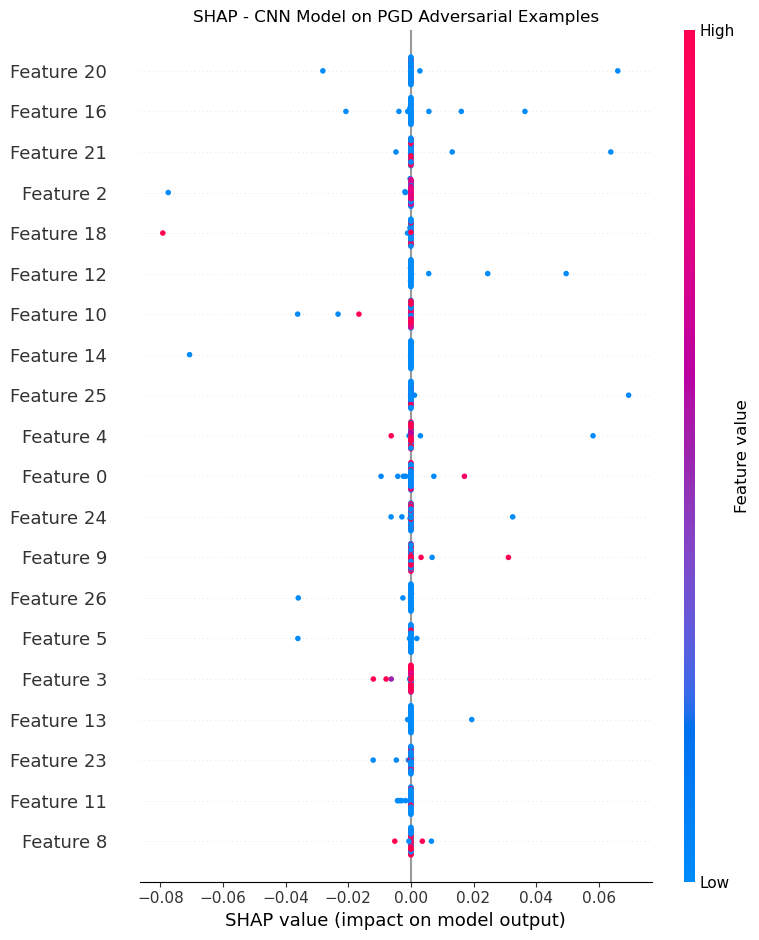

In [117]:
plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on PGD Adversarial Examples")
shap.summary_plot(shap_values_pgd_cnn, X_test_pgd_sample_reduced, plot_type="dot")

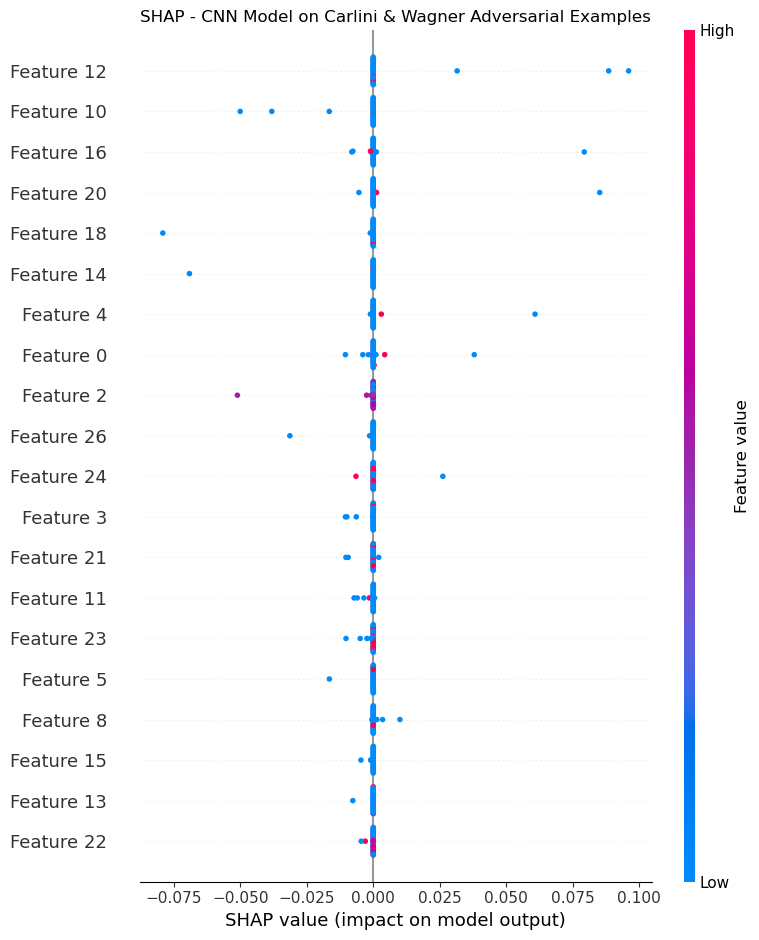

In [123]:

plt.figure(figsize=(10, 6))
plt.title("SHAP - CNN Model on Carlini & Wagner Adversarial Examples")
shap.summary_plot(shap_values_cw_cnn, X_test_cw_sample_reduced, plot_type="dot")